<h1><center>DSA 4212: Year 2022</center></h1>
<h3><center> Assignment 2 Question 2  </center></h3>
<h4><center> Group Number: 9 </center></h4>
<h4><center> Group Member 1: Lee Wei Qing, A0205666B </center></h4>
<h4><center> Group Member 2: Madeline Lim Chia Bing, A0205053W </center></h4>
<h4><center> Group Member 3: Mabel Lee Wei Ling, A0204397B </center></h4>
<h4><center> Group Member 4: Wu Wei Ye, A0200578H </center></h4>



# **Assignment 2 Task**
### 1. Implement Collaborative filtering algorithm from scratch
### 2. For evaluating your method, you will use a random training set containing 90% of the available ratings andwill report the Root Mean Squared Error (RMSE) on the remaining 10%.
### 3. You are encouraged to try several approaches 
### 4. Read the relevant recent literature on the problem.

 
## **Contents**
## 1. Data Cleaning
## 2. Data Exploration
## 3. Models
> ## 3.1. Matrix Factorisation with Genre Matrix
>> ### 3.1.1 Stochastic Gradient Descent(SGD)
>> ### 3.1.2 Stochastic Gradient Descent with momentum (SGDM)
>> ### 3.1.3 L-BFGS

> ## 2. Low Rank Matrix Factorisation
>> ### 3.2.1 Stochastic Gradient Descent with momentum (SGDM)
>> ### 3.2.2 L-BFGS




# 1. Data Cleaning

In [ ]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True) # for higher accuracy

import jax
import jax.numpy as np
import numpy as onp
import pylab as plt
import os
import pandas as pd
import time

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#load attributes csv file
path = "/content/drive/MyDrive/DSA4212_Project/Assignment2/Dataset/"

In [ ]:
movies_data = pd.read_csv(os.path.join(path, "movies.dat"), encoding='latin-1', sep='::' , header=None, engine='python')
ratings_data = pd.read_csv(os.path.join(path, "ratings.dat"), sep='::', header=None, engine='python')
users_data = pd.read_csv(os.path.join(path, "users.dat"), sep='::', header=None, engine='python')

## Movies 

In [ ]:
# cleaning up movie dataset
movies_data1 = []
for i in range(len(movies_data)):
  movie_id = [movies_data.iloc[i,0]]
  movies_data1 = movies_data1 + [ movie_id + [y] + [i]  for y in movies_data.iloc[i,2].split('|')]

movies_df = pd.DataFrame(movies_data1, columns = ['Movie_ID', 'genre', 'id'])
movies_df

,Movie_ID,genre,id
0,1,Animation,0
1,1,Children's,0
2,1,Comedy,0
3,2,Adventure,1
4,2,Children's,1
...,...,...,...
6403,3949,Drama,3879
6404,3950,Drama,3880
6405,3951,Drama,3881
6406,3952,Drama,3882


In [ ]:
# pivot wider the genres
genre_dummies = pd.get_dummies(movies_df.genre)
movies_df1 = pd.concat((movies_df[['Movie_ID', 'id']], genre_dummies), axis = 1)

# movies dataset
movies_df1 = movies_df1.groupby(['Movie_ID', 'id']).sum().reset_index()
movies_df1 

,Movie_ID,id,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,3878,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3879,3949,3879,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3880,3950,3880,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3881,3951,3881,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


## Ratings

In [ ]:
# ratings dataset
ratings_data.columns = ['User_ID', 'Movie_ID', 'Rating', 'Timestamp']
ratings_df = ratings_data[['User_ID', 'Movie_ID', 'Rating']]
ratings_df

,User_ID,Movie_ID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


In [ ]:
ratings_df = pd.merge(ratings_df, movies_df, on = 'Movie_ID')
ratings_df

,User_ID,Movie_ID,Rating,genre,id
0,1,1193,5,Drama,1176
1,2,1193,5,Drama,1176
2,12,1193,4,Drama,1176
3,15,1193,4,Drama,1176
4,17,1193,5,Drama,1176
...,...,...,...,...,...
2101810,5780,2845,1,Drama,2776
2101811,5851,3607,5,Comedy,3538
2101812,5851,3607,5,Drama,3538
2101813,5851,3607,5,Western,3538


## Users

In [ ]:
# user dataset
users_data.columns = ['User_ID', 'Gender', 'Age', 'Occupation', 'Zip-code']
users_df = users_data[['User_ID', 'Gender', 'Age', 'Occupation']]
users_df

,User_ID,Gender,Age,Occupation
0,1,F,1,10
1,2,M,56,16
2,3,M,25,15
3,4,M,45,7
4,5,M,25,20
...,...,...,...,...
6035,6036,F,25,15
6036,6037,F,45,1
6037,6038,F,56,1
6038,6039,F,45,0


# 2. Data Exploration

In [ ]:
# combining the user, rating and movie dataset
user_ratings = pd.merge(users_df, ratings_df, on = 'User_ID')
user_ratings_movies = pd.merge(user_ratings, movies_df1, on = 'Movie_ID')

user_ratings_movies

,User_ID,Gender,Age,Occupation,Movie_ID,Rating,genre,id_x,id_y,Action,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,F,1,10,1193,5,Drama,1176,1176,0,...,0,0,0,0,0,0,0,0,0,0
1,2,M,56,16,1193,5,Drama,1176,1176,0,...,0,0,0,0,0,0,0,0,0,0
2,12,M,25,12,1193,4,Drama,1176,1176,0,...,0,0,0,0,0,0,0,0,0,0
3,15,M,25,7,1193,4,Drama,1176,1176,0,...,0,0,0,0,0,0,0,0,0,0
4,17,M,50,1,1193,5,Drama,1176,1176,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101810,5780,M,18,17,2845,1,Drama,2776,2776,0,...,0,0,0,0,0,0,0,0,0,0
2101811,5851,F,18,20,3607,5,Comedy,3538,3538,0,...,0,0,0,0,0,0,0,0,0,1
2101812,5851,F,18,20,3607,5,Drama,3538,3538,0,...,0,0,0,0,0,0,0,0,0,1
2101813,5851,F,18,20,3607,5,Western,3538,3538,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# movie average ratings and unique number of users that rated
movie_avgrating = user_ratings_movies.groupby(['Movie_ID']).agg(
    avg_rating = pd.NamedAgg(column='Rating', aggfunc = 'mean'),
    num_users_rated = pd.NamedAgg(column = 'User_ID', aggfunc= 'nunique')).reset_index()
movie_avgrating.sort_values(by = ['num_users_rated', 'avg_rating'], ascending = False)

,Movie_ID,avg_rating,num_users_rated
2651,2858,4.317386,3428
253,260,4.453694,2991
1106,1196,4.292977,2990
1120,1210,4.022893,2883
466,480,3.763847,2672
...,...,...,...
3013,3237,1.000000,1
3086,3312,1.000000,1
3146,3376,1.000000,1
3227,3460,1.000000,1


In [ ]:
# User's average rating and unique number of movies it has rated
user_avgrating = user_ratings_movies.groupby(['User_ID']).agg(
    avg_rating = pd.NamedAgg(column='Rating', aggfunc = 'mean'),
    num_movies_rated = pd.NamedAgg(column = 'Movie_ID', aggfunc= 'nunique')).reset_index()
user_avgrating.sort_values(by = ['num_movies_rated', 'avg_rating'], ascending = False)

,User_ID,avg_rating,num_movies_rated
4168,4169,3.555916,2314
1679,1680,3.527632,1850
4276,4277,4.126536,1743
1940,1941,3.130960,1595
1180,1181,2.819269,1521
...,...,...,...
946,947,3.062500,20
571,572,3.051282,20
2380,2381,3.028571,20
5827,5828,2.944444,20


# 3. Models

In [ ]:
ratings_df = ratings_df.drop_duplicates(subset = ['User_ID', 'id'], keep='last')

In [ ]:
train_df = ratings_df.groupby('User_ID', group_keys=False).apply(lambda x: x.sample(frac=0.9, random_state=2603))
test_df = ratings_df[~ratings_df.index.isin(train_df.index)].reset_index(drop=True)
train_df = train_df.reset_index(drop=True)

In [ ]:
train_df

,User_ID,Movie_ID,Rating,genre,id
0,1,1545,4,Drama,1506
1,1,150,5,Drama,148
2,1,1022,5,Musical,1009
3,1,914,3,Romance,902
4,1,1028,5,Musical,1015
...,...,...,...,...,...
900189,6040,1172,4,Romance,1156
900190,6040,1248,4,Thriller,1228
900191,6040,3067,4,Drama,2998
900192,6040,357,3,Romance,353


In [ ]:
test_df

,User_ID,Movie_ID,Rating,genre,id
0,12,1193,4,Drama,1176
1,15,1193,4,Drama,1176
2,17,1193,5,Drama,1176
3,18,1193,4,Drama,1176
4,19,1193,5,Drama,1176
...,...,...,...,...,...
100010,4101,226,2,Thriller,223
100011,4169,827,3,Drama,816
100012,5334,3123,1,Comedy,3054
100013,4628,1832,4,Drama,1764


In [ ]:
u_list_train = onp.array(train_df['User_ID'] - 1)
f_list_train = onp.array(train_df['id'])
u_list_test = np.array(test_df['User_ID'] - 1)
f_list_test = np.array(test_df['id'])
y_train = train_df['Rating']
y_test = test_df['Rating']

In [ ]:
u_list_train

array([   0,    0,    0, ..., 6039, 6039, 6039])

In [ ]:
X = movies_df1.loc[:, 'Action':]

In [ ]:
X = np.array(X).reshape(3883, 18).astype('float64')
X = X.T

In [ ]:
X 

DeviceArray([[0., 0., 0., ..., 0., 0., 0.],
             [0., 1., 0., ..., 0., 0., 0.],
             [1., 0., 0., ..., 0., 0., 0.],
             ...,
             [0., 0., 0., ..., 0., 0., 1.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.]], dtype=float64)

In [ ]:
onp.random.seed(2603)
beta_init = onp.random.normal(0, scale=1/np.sqrt(6040 * 18), size=(6040 * 18)).reshape(6040, 18)

In [ ]:
def MSE(U,V,Y,u_list_train,f_list_train):
    predictions = (U @ V)[u_list_train.astype(int), f_list_train.astype(int)]
    errors = Y - predictions
    return np.mean(errors**2)

# rest is the same
MSE_grad_u = jax.jit(jax.grad(MSE, argnums=0))
MSE_grad_v = jax.jit(jax.grad(MSE, argnums=1))

In [ ]:
def RMSE(U,V,Y,u_list_train,f_list_train):
    predictions = (U @ V)[u_list_train.astype(int), f_list_train.astype(int)]
    errors = Y - predictions
    return (np.mean(errors**2))**(1/2)

RMSE_grad_u = jax.jit(jax.grad(RMSE, argnums=0))
RMSE_grad_v = jax.jit(jax.grad(RMSE, argnums=1))

# 3.1 Matrix Factorisation with Genre Matrix

## 3.1.1 Stochastic Gradient Descent

In [ ]:
# SGD
n = 100
m = 5000
beta = onp.copy(beta_init)
x = onp.copy(X)
y = onp.copy(y_train)
learning_rate = 0.9

start_time = time.time()
N = len(u_list_train)
img_indices = onp.arange(N)

loss_history = []
loss_history_end_epoch = []
for epoch in range(n):
    n_minibatch = N // m + 1
    onp.random.shuffle(img_indices)

    all_loss_within_epoch = []
    for k in range(n_minibatch):
        batch_indices = onp.arange(k*m, (k+1)*m) % N
        batch_indices = img_indices[batch_indices]
        u_minibatch = u_list_train[batch_indices]
        f_minibatch = f_list_train[batch_indices]
        y_minibatch = y[batch_indices]

        grad_beta = MSE_grad_u(beta, x, y_minibatch, u_minibatch, f_minibatch)
        grad_x = MSE_grad_v(beta, x, y_minibatch, u_minibatch, f_minibatch)
        
        beta = beta - learning_rate * grad_beta
        x = x - learning_rate * grad_x

        loss_history.append(MSE(beta, x, y,u_list_train,f_list_train))
        all_loss_within_epoch.append(MSE(beta, x, y,u_list_train,f_list_train))
    cur_loss = onp.mean(all_loss_within_epoch)
    loss_history_end_epoch.append(cur_loss)
    err_train = MSE(beta, x, y,u_list_train,f_list_train)
    err_val = MSE(beta, x, onp.copy(y_test), u_list_test,f_list_test)        
    print(f"epoch:{epoch} \t Loss:{cur_loss:2.3f}  \t MSE(train):{err_train:2.5f} \t MSE(val):{err_val:2.5f}")
print("Took", time.time() - start_time, "s to run.")

epoch:0 	 Loss:13.963  	 MSE(train):13.86044 	 MSE(val):13.94882
epoch:1 	 Loss:13.756  	 MSE(train):13.65317 	 MSE(val):13.74381
epoch:2 	 Loss:13.547  	 MSE(train):13.44125 	 MSE(val):13.53399
epoch:3 	 Loss:13.331  	 MSE(train):13.22044 	 MSE(val):13.31508
epoch:4 	 Loss:13.104  	 MSE(train):12.98657 	 MSE(val):13.08285
epoch:5 	 Loss:12.862  	 MSE(train):12.73568 	 MSE(val):12.83329
epoch:6 	 Loss:12.601  	 MSE(train):12.46382 	 MSE(val):12.56237
epoch:7 	 Loss:12.317  	 MSE(train):12.16732 	 MSE(val):12.26633
epoch:8 	 Loss:12.007  	 MSE(train):11.84278 	 MSE(val):11.94169
epoch:9 	 Loss:11.667  	 MSE(train):11.48731 	 MSE(val):11.58546
epoch:10 	 Loss:11.295  	 MSE(train):11.09879 	 MSE(val):11.19540
epoch:11 	 Loss:10.889  	 MSE(train):10.67610 	 MSE(val):10.77030
epoch:12 	 Loss:10.449  	 MSE(train):10.21963 	 MSE(val):10.31045
epoch:13 	 Loss:9.977  	 MSE(train):9.73147 	 MSE(val):9.81793
epoch:14 	 Loss:9.474  	 MSE(train):9.21583 	 MSE(val):9.29693
epoch:15 	 Loss:8.948  	 M

In [ ]:
# Train RMSE
RMSE(beta,x,y,u_list_train,f_list_train)

DeviceArray(0.88184344, dtype=float64)

In [ ]:
# Test RMSE
RMSE(beta,x,onp.copy(y_test),u_list_test,f_list_test)

DeviceArray(0.90687828, dtype=float64)

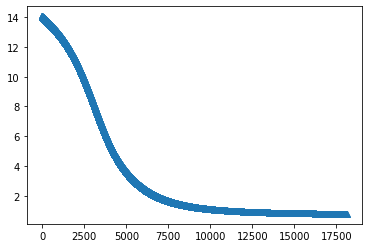

In [ ]:
plt.plot(loss_history, "-^")

Text(0.5, 0, 'epoch')

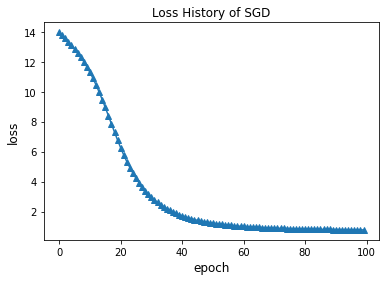

In [ ]:
plt.plot(loss_history_end_epoch, "-^")
plt.title("Loss History of SGD")
plt.ylabel("loss", fontsize = 12)
plt.xlabel("epoch", fontsize = 12)

## 3.1.2 Stochastic Gradient Descent (SGD) with Momentum

In [ ]:
# SGD with momentum 

n = 30
m = 5000
beta = onp.copy(beta_init)
x = onp.copy(X)
y = onp.copy(y_train)
learning_rate = 0.9
gamma = 0.9

start_time = time.time()
beta_previous = onp.copy(beta)
x_previous = onp.copy(x)
N = len(u_list_train)
img_indices = onp.arange(N)

loss_history = []
train_list = []
val_list = []
loss_history_end_epoch = []
for epoch in range(n):
    n_minibatch = N // m + 1
    onp.random.shuffle(img_indices)

    all_loss_within_epoch = []
    for k in range(n_minibatch):
        batch_indices = onp.arange(k*m, (k+1)*m) % N
        batch_indices = img_indices[batch_indices]
        u_minibatch = u_list_train[batch_indices]
        f_minibatch = f_list_train[batch_indices]
        y_minibatch = y[batch_indices]

        grad_beta = RMSE_grad_u(beta, x, y_minibatch, u_minibatch, f_minibatch)
        grad_x = RMSE_grad_v(beta, x, y_minibatch, u_minibatch, f_minibatch)
        
        temp_beta = beta
        beta = temp_beta - learning_rate * grad_beta + gamma * (temp_beta - beta_previous)
        beta_previous = temp_beta

        temp_x = x
        x = temp_x - learning_rate * grad_x + gamma * (temp_x - x_previous)
        x_previous = temp_x

        loss_history.append(RMSE(beta, x, y,u_list_train,f_list_train))
        all_loss_within_epoch.append(RMSE(beta, x, y,u_list_train,f_list_train))

    cur_loss = onp.mean(all_loss_within_epoch)
    loss_history_end_epoch.append(cur_loss)
    
    # print train and test MSE
    err_train = RMSE(beta, x, y,u_list_train,f_list_train)
    train_list.append(err_train)
    err_val = RMSE(beta, x, onp.copy(y_test), u_list_test,f_list_test)   
    val_list.append(err_val)     
    print(f"epoch:{epoch} \t Loss:{cur_loss:2.3f}  \t RMSE(train):{err_train:2.4f} \t RMSE(val):{err_val:2.4f}")
print("Took", time.time() - start_time, "s to run.")

epoch:0 	 Loss:3.612  	 RMSE(train):3.4294 	 RMSE(val):3.4439
epoch:1 	 Loss:3.088  	 RMSE(train):2.6586 	 RMSE(val):2.6688
epoch:2 	 Loss:2.205  	 RMSE(train):1.8252 	 RMSE(val):1.8315
epoch:3 	 Loss:1.568  	 RMSE(train):1.3631 	 RMSE(val):1.3674
epoch:4 	 Loss:1.234  	 RMSE(train):1.1326 	 RMSE(val):1.1428
epoch:5 	 Loss:1.069  	 RMSE(train):1.0181 	 RMSE(val):1.0313
epoch:6 	 Loss:0.985  	 RMSE(train):0.9575 	 RMSE(val):0.9732
epoch:7 	 Loss:0.939  	 RMSE(train):0.9225 	 RMSE(val):0.9412
epoch:8 	 Loss:0.911  	 RMSE(train):0.9001 	 RMSE(val):0.9221
epoch:9 	 Loss:0.892  	 RMSE(train):0.8847 	 RMSE(val):0.9095
epoch:10 	 Loss:0.879  	 RMSE(train):0.8729 	 RMSE(val):0.9002
epoch:11 	 Loss:0.869  	 RMSE(train):0.8636 	 RMSE(val):0.8930
epoch:12 	 Loss:0.860  	 RMSE(train):0.8556 	 RMSE(val):0.8875
epoch:13 	 Loss:0.852  	 RMSE(train):0.8486 	 RMSE(val):0.8831
epoch:14 	 Loss:0.846  	 RMSE(train):0.8424 	 RMSE(val):0.8792
epoch:15 	 Loss:0.840  	 RMSE(train):0.8368 	 RMSE(val):0.8758
ep

Text(0.5, 0, 'time')

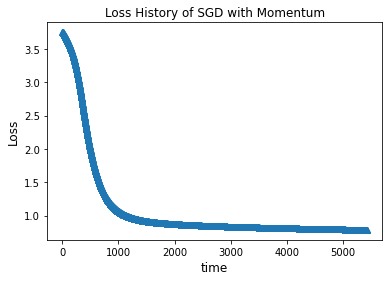

In [ ]:
plt.plot(loss_history, "-^")
plt.title("Loss History of SGD with Momentum")
plt.ylabel("Loss", fontsize = 12)
plt.xlabel("time", fontsize = 12)

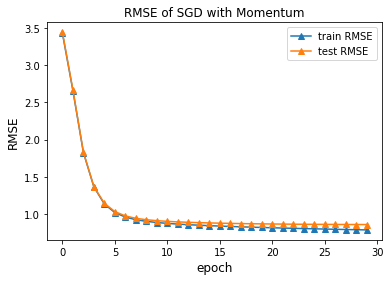

In [ ]:
plt.plot(train_list, "-^", label = 'train RMSE')
plt.plot(val_list, "-^", label = 'test RMSE')
plt.title("RMSE of SGD with Momentum")
plt.ylabel("RMSE", fontsize = 12)
plt.xlabel("epoch", fontsize = 12)
plt.legend()

In [ ]:
# actual rating
y_test[0]

4

In [ ]:
# predicted rating
(beta @ x)[u_list_test.astype(int), f_list_test.astype(int)][0]

DeviceArray(4.48929139, dtype=float64)

In [ ]:
# Train RSME
RMSE(beta, x, y, u_list_train,f_list_train)

DeviceArray(0.78517146, dtype=float64)

In [ ]:
# Test RSME
RMSE(beta, x, onp.copy(y_test), u_list_test,f_list_test) 

DeviceArray(0.85736949, dtype=float64)

## 3.1.3 L-BFGS

In [ ]:
import scipy

In [ ]:
def make_positive(x):
    """ transform x into a positive number """
    return np.log(1. + np.exp(x))

In [ ]:
# initiation
beta = onp.copy(beta_init)
x = onp.copy(X)
y = onp.copy(y_train)

In [ ]:
# get the dimensions

x_dimx, x_dimy = x.shape
beta_dimx, beta_dimy = beta.shape

# we will concatenate all these coefficients and atoms into a long vector and apply LBFGS on that
# this long vector if parameter will have dimension: atom_dimx*atom_dimy + coefs_dimx*coefs_dimy
param_dim = x_dimx * x_dimy + beta_dimx * beta_dimy 

# generate a random initial parameter
param_init = onp.random.normal(0, 1/param_dim, size=param_dim)

@jax.jit
def extract_x_and_beta(param):
    """ helper function to extract the beta and x out of the long parameter vector """
    x = param[(beta_dimx * beta_dimy):]
    beta = param[:(beta_dimx * beta_dimy)]
    return x, beta

@jax.jit
def loss_RMSE(param, y, u_list, f_list):
    # extract the log x and beta
    x_, beta_ = extract_x_and_beta(param)

    # make it positive by applying the function log(1+exp(x))
    beta1 = make_positive(beta_).reshape(beta_dimx, beta_dimy)
    x1 = make_positive(x_).reshape(x_dimx, x_dimy)
    
    # mean squared error 
    result = RMSE(beta1, x1, y, u_list, f_list)
    return result
# automatic differentiation magic here!
loss_RMSE_grad = jax.jit(jax.grad(loss_RMSE))

#let's create a wrapper to make sure the output is a standard numpy gradient
def loss_RMSE_grad_wrapper(param, y, u_list, f_list):
    return onp.array(loss_RMSE_grad(param, y, u_list, f_list))

In [ ]:
loss_history = []  #to save the loss trajectory
time_history = []  #to save the compute time
train_err = [] # to save the train error
test_err = [] # to save the test error
iteration_index = 0

def save_traj(param):
    """ a function that saves a few statistics for later analysis"""
    global iteration_index
    iteration_index += 1
    current_loss = loss_RMSE(param, y, u_list_train, f_list_train)
    current_loss_test = loss_RMSE(param, onp.copy(y_test), u_list_test, f_list_test)

    # display the loss every 10 iterations
    if iteration_index % 10 == 0:
        print(f"iteration:{iteration_index} \t \t RMSE(train):{current_loss:5.5} \t RMSE(val):{current_loss_test:5.5}")
        train_err.append(current_loss)
        test_err.append(current_loss_test)
    # record everything
    loss_history.append(current_loss)
    time_history.append(time.time() - start)
    
start = time.time()
traj = scipy.optimize.minimize(fun = lambda x: loss_RMSE(param = x, y = y, u_list = u_list_train, f_list = f_list_train), #functino to minimize
                                x0 = param_init, #initial guess
                                method = 'L-BFGS-B',  #we want to use L-BFGS
                                jac = lambda x: loss_RMSE_grad_wrapper(param = x, y = y, u_list = u_list_train, f_list = f_list_train), #function that computes the gradient
                                callback = save_traj, #a function used to save some results for later pltting
                                tol = 10**-10,
                                options={"maxiter":250})  #maximum number of iteration

iteration:10 	 	 RMSE(train):1.0467 	 RMSE(val):1.0509
iteration:20 	 	 RMSE(train):0.95076 	 RMSE(val):0.95803
iteration:30 	 	 RMSE(train):0.94053 	 RMSE(val):0.94896
iteration:40 	 	 RMSE(train):0.93827 	 RMSE(val):0.94719
iteration:50 	 	 RMSE(train):0.93748 	 RMSE(val):0.94657
iteration:60 	 	 RMSE(train):0.93713 	 RMSE(val):0.94626
iteration:70 	 	 RMSE(train):0.93694 	 RMSE(val):0.94613
iteration:80 	 	 RMSE(train):0.93683 	 RMSE(val):0.94611
iteration:90 	 	 RMSE(train):0.93677 	 RMSE(val):0.9461
iteration:100 	 	 RMSE(train):0.93673 	 RMSE(val):0.94613
iteration:110 	 	 RMSE(train):0.93605 	 RMSE(val):0.94569
iteration:120 	 	 RMSE(train):0.92089 	 RMSE(val):0.93397
iteration:130 	 	 RMSE(train):0.90195 	 RMSE(val):0.92166
iteration:140 	 	 RMSE(train):0.8797 	 RMSE(val):0.91093
iteration:150 	 	 RMSE(train):0.85805 	 RMSE(val):0.90599
iteration:160 	 	 RMSE(train):0.83872 	 RMSE(val):0.90165
iteration:170 	 	 RMSE(train):0.82221 	 RMSE(val):0.90291
iteration:180 	 	 RMSE(trai

Text(0, 0.5, 'RMSE reconstruction')

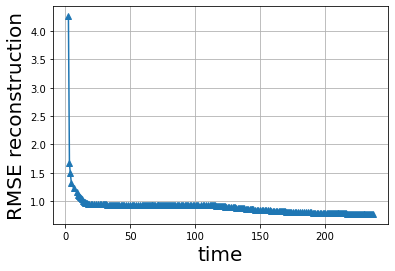

In [ ]:
plt.plot(time_history, loss_history, "-^")
plt.grid(True)
plt.xlabel("time", fontsize=20)
plt.ylabel("RMSE reconstruction", fontsize=20)

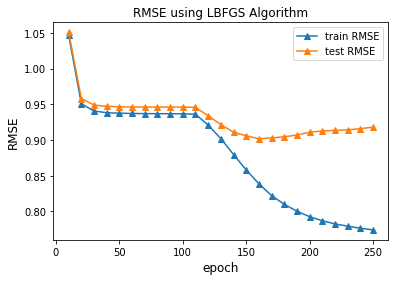

In [ ]:
iter = list(range(10, 260, 10))
plt.plot(iter, train_err, "-^", label = 'train RMSE')
plt.plot(iter, test_err, "-^", label = 'test RMSE')
plt.title("RMSE using LBFGS Algorithm")
plt.ylabel("RMSE", fontsize = 12)
plt.xlabel("epoch", fontsize = 12)
plt.legend()

In [ ]:
# train mse
loss_RMSE(traj["x"], y = y, u_list = u_list_train, f_list = f_list_train)

DeviceArray(0.77410164, dtype=float64)

In [ ]:
# test mse
loss_RMSE(traj["x"], onp.copy(y_test), u_list_test, f_list_test)

DeviceArray(0.91793819, dtype=float64)

In [ ]:
def RMSE(U,V,Y,u_list_train,f_list_train):
    predictions = (U @ V)[u_list_train.astype(int), f_list_train.astype(int)]
    errors = Y - predictions
    return (np.mean(errors**2))**(1/2)

@jax.jit
def loss_RMSE(param, y, u_list, f_list):
    # extract the log atoms and coefs
    x_, beta_ = extract_x_and_beta(param)

    # make it positive by applying the function log(1+exp(x))
    beta1 = make_positive(beta_).reshape(beta_dimx, beta_dimy)
    x1 = make_positive(x_).reshape(x_dimx, x_dimy)
    
    # mean squared error 
    result = RMSE(beta1, x1, y, u_list, f_list)
    return result

In [ ]:
# test Rmse
loss_RMSE(traj["x"], onp.copy(y_test), u_list_test, f_list_test)

DeviceArray(0.91793819, dtype=float64)

# 3.2 Low Rank Matrix Factorisation

## 3.2.1 SGDM
### Cross Validation to choose best R

In this section, we tried training our models on a range of different ranks to choose an optimal value for the rank.

In [ ]:
ratings_df = ratings_df.drop_duplicates(subset = ['User_ID', 'id'], keep='last')

In [ ]:
train_df1 = ratings_df.groupby('User_ID', group_keys=False).apply(lambda x: x.sample(frac=0.9, random_state=2603))
train_df2 = train_df1.groupby('User_ID', group_keys=False).apply(lambda x: x.sample(frac=0.9, random_state=4212))
val_df2 = ratings_df[~ratings_df.index.isin(train_df2.index)].reset_index(drop=True)
train_df2 = train_df2.reset_index(drop=True)

In [ ]:
u_list_train2 = onp.array(train_df2['User_ID'] - 1)
f_list_train2 = onp.array(train_df2['id'])
u_list_test2 = np.array(val_df2['User_ID'] - 1)
f_list_test2 = np.array(val_df2['id'])
y_train2 = train_df2['Rating']
y_val2 = val_df2['Rating']

In [ ]:
values = [1,2,5,10,20,50]
err_train_list = []
err_test_list = []

for i in range(0,6):

  r = values[i]
  onp.random.seed(2603)
  beta_init = onp.random.normal(0, scale=1, size=(6040 * r)).reshape(6040, r)
  X = onp.random.normal(0, scale=1, size=(r * 3883)).reshape(r, 3883)

  n = 30
  m = 5000
  beta = onp.copy(beta_init)
  x = onp.copy(X)
  y = onp.copy(y_train2)
  learning_rate = 0.9
  gamma = 0.9

  start_time = time.time()
  beta_previous = onp.copy(beta)
  x_previous = onp.copy(x)
  N = len(u_list_train2)
  img_indices = onp.arange(N)

  loss_history = []
  train_list = []
  val_list = []
  loss_history_end_epoch = []
  for epoch in range(n):
      n_minibatch = N // m + 1
      onp.random.shuffle(img_indices)

      all_loss_within_epoch = []
      for k in range(n_minibatch):
          batch_indices = onp.arange(k*m, (k+1)*m) % N
          batch_indices = img_indices[batch_indices]
          u_minibatch = u_list_train2[batch_indices]
          f_minibatch = f_list_train2[batch_indices]
          y_minibatch = y[batch_indices]

          grad_beta = MSE_grad_u(beta, x, y_minibatch, u_minibatch, f_minibatch)
          grad_x = MSE_grad_v(beta, x, y_minibatch, u_minibatch, f_minibatch)
          
          temp_beta = beta
          beta = temp_beta - learning_rate * grad_beta + gamma * (temp_beta - beta_previous)
          beta_previous = temp_beta

          temp_x = x
          x = temp_x - learning_rate * grad_x + gamma * (temp_x - x_previous)
          x_previous = temp_x

          loss_history.append(MSE(beta, x, y,u_list_train2,f_list_train2))
          all_loss_within_epoch.append(MSE(beta, x, y,u_list_train2,f_list_train2))
          # test_all_loss_within_epoch.append(MSE(beta, x, onp.copy(y_test), u_list_test,f_list_test))

      cur_loss = onp.mean(all_loss_within_epoch)
      loss_history_end_epoch.append(cur_loss)

      # print train and test MSE
      err_train = MSE(beta, x, y,u_list_train2,f_list_train2)
      train_list.append(err_train)
      err_val = MSE(beta, x, onp.copy(y_val2), u_list_test2,f_list_test2)   
      val_list.append(err_val)     
      print(f"epoch:{epoch} \t Loss:{cur_loss:2.3f}  \t MSE(train):{err_train:2.4f} \t MSE(val):{err_val:2.4f}")

  err_train = MSE(beta, x, y,u_list_train2,f_list_train2)
  err_train_list.append(err_train)
  err_val = MSE(beta, x, onp.copy(y_val2), u_list_test2,f_list_test2)   
  err_test_list.append(err_val)     
  print(f"rank:{r} \t MSE(train):{err_train:2.4f} \t MSE(val):{err_val:2.4f}")

epoch:0 	 Loss:14.251  	 MSE(train):13.6379 	 MSE(val):13.7100
epoch:1 	 Loss:7.825  	 MSE(train):2.8438 	 MSE(val):2.8120
epoch:2 	 Loss:1.840  	 MSE(train):1.3182 	 MSE(val):1.3230
epoch:3 	 Loss:1.141  	 MSE(train):1.0219 	 MSE(val):1.0346
epoch:4 	 Loss:0.966  	 MSE(train):0.9240 	 MSE(val):0.9405
epoch:5 	 Loss:0.901  	 MSE(train):0.8818 	 MSE(val):0.8997
epoch:6 	 Loss:0.871  	 MSE(train):0.8609 	 MSE(val):0.8801
epoch:7 	 Loss:0.856  	 MSE(train):0.8492 	 MSE(val):0.8692
epoch:8 	 Loss:0.846  	 MSE(train):0.8415 	 MSE(val):0.8618
epoch:9 	 Loss:0.840  	 MSE(train):0.8370 	 MSE(val):0.8568
epoch:10 	 Loss:0.836  	 MSE(train):0.8339 	 MSE(val):0.8551
epoch:11 	 Loss:0.834  	 MSE(train):0.8317 	 MSE(val):0.8524
epoch:12 	 Loss:0.831  	 MSE(train):0.8294 	 MSE(val):0.8500
epoch:13 	 Loss:0.830  	 MSE(train):0.8282 	 MSE(val):0.8489
epoch:14 	 Loss:0.829  	 MSE(train):0.8270 	 MSE(val):0.8479
epoch:15 	 Loss:0.828  	 MSE(train):0.8260 	 MSE(val):0.8470
epoch:16 	 Loss:0.827  	 MSE(tr

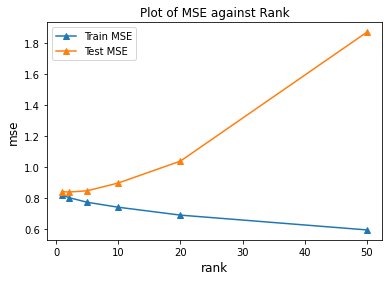

In [ ]:
plt.plot(values, err_train_list, "-^", label = 'Train MSE')
plt.plot(values, err_test_list, "-^", label = 'Test MSE')
plt.title("Plot of MSE against Rank")

plt.ylabel("mse", fontsize = 12)
plt.xlabel("rank", fontsize = 12)
plt.legend()

In [ ]:
def RMSE(U,V,Y,u_list_train,f_list_train):
    predictions = (U @ V)[u_list_train.astype(int), f_list_train.astype(int)]
    errors = Y - predictions
    return np.sqrt(np.mean(errors**2))

# rest is the same
RMSE_grad_u = jax.jit(jax.grad(RMSE, argnums=0))
RMSE_grad_v = jax.jit(jax.grad(RMSE, argnums=1))

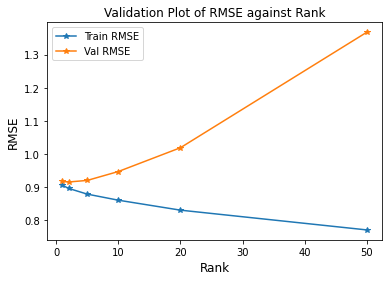

In [ ]:
values_full = [1,2,5,10,20,50]
val_full = [np.sqrt(0.8421), np.sqrt(0.8389), np.sqrt(0.8476), np.sqrt(0.8976), np.sqrt(1.0386), np.sqrt(1.8689)]
train_full = [np.sqrt(0.8209), np.sqrt(0.8038), np.sqrt(0.7732), np.sqrt(0.7414), np.sqrt(0.6906), np.sqrt(0.5952)]
plt.plot(values_full, train_full, "-*", label = 'Train RMSE')
plt.plot(values_full, val_full, "-*", label = 'Val RMSE')
plt.title("Validation Plot of RMSE against Rank")

plt.ylabel("RMSE", fontsize = 12)
plt.xlabel("Rank", fontsize = 12)
plt.legend()

In [ ]:
values = [1,3,5,7,9]
err_train_list = []
err_test_list = []

for i in range(0,5):

  r = values[i]
  onp.random.seed(2603)
  beta_init = onp.random.normal(0, scale=1, size=(6040 * r)).reshape(6040, r)
  X = onp.random.normal(0, scale=1, size=(r * 3883)).reshape(r, 3883)

  n = 30
  m = 5000
  beta = onp.copy(beta_init)
  x = onp.copy(X)
  y = onp.copy(y_train2)
  learning_rate = 0.9
  gamma = 0.9

  start_time = time.time()
  beta_previous = onp.copy(beta)
  x_previous = onp.copy(x)
  N = len(u_list_train2)
  img_indices = onp.arange(N)

  loss_history = []
  train_list = []
  val_list = []
  loss_history_end_epoch = []
  for epoch in range(n):
      n_minibatch = N // m + 1
      onp.random.shuffle(img_indices)

      all_loss_within_epoch = []
      for k in range(n_minibatch):
          batch_indices = onp.arange(k*m, (k+1)*m) % N
          batch_indices = img_indices[batch_indices]
          u_minibatch = u_list_train2[batch_indices]
          f_minibatch = f_list_train2[batch_indices]
          y_minibatch = y[batch_indices]

          grad_beta = MSE_grad_u(beta, x, y_minibatch, u_minibatch, f_minibatch)
          grad_x = MSE_grad_v(beta, x, y_minibatch, u_minibatch, f_minibatch)
          
          temp_beta = beta
          beta = temp_beta - learning_rate * grad_beta + gamma * (temp_beta - beta_previous)
          beta_previous = temp_beta

          temp_x = x
          x = temp_x - learning_rate * grad_x + gamma * (temp_x - x_previous)
          x_previous = temp_x

          loss_history.append(MSE(beta, x, y,u_list_train2,f_list_train2))
          all_loss_within_epoch.append(MSE(beta, x, y,u_list_train2,f_list_train2))
          # test_all_loss_within_epoch.append(MSE(beta, x, onp.copy(y_test), u_list_test,f_list_test))

      cur_loss = onp.mean(all_loss_within_epoch)
      loss_history_end_epoch.append(cur_loss)

      # print train and test MSE
      err_train = MSE(beta, x, y,u_list_train2,f_list_train2)
      train_list.append(err_train)
      err_val = MSE(beta, x, onp.copy(y_val2), u_list_test2,f_list_test2)   
      val_list.append(err_val)     
      print(f"epoch:{epoch} \t Loss:{cur_loss:2.3f}  \t MSE(train):{err_train:2.4f} \t MSE(val):{err_val:2.4f}")

  err_train = MSE(beta, x, y,u_list_train2,f_list_train2)
  err_train_list.append(err_train)
  err_val = MSE(beta, x, onp.copy(y_val2), u_list_test2,f_list_test2)   
  err_test_list.append(err_val)     
  print(f"rank:{r} \t MSE(train):{err_train:2.4f} \t MSE(val):{err_val:2.4f}")

epoch:0 	 Loss:14.251  	 MSE(train):13.6379 	 MSE(val):13.7100
epoch:1 	 Loss:7.825  	 MSE(train):2.8438 	 MSE(val):2.8120
epoch:2 	 Loss:1.840  	 MSE(train):1.3182 	 MSE(val):1.3230
epoch:3 	 Loss:1.141  	 MSE(train):1.0219 	 MSE(val):1.0346
epoch:4 	 Loss:0.966  	 MSE(train):0.9240 	 MSE(val):0.9405
epoch:5 	 Loss:0.901  	 MSE(train):0.8818 	 MSE(val):0.8997
epoch:6 	 Loss:0.871  	 MSE(train):0.8609 	 MSE(val):0.8801
epoch:7 	 Loss:0.856  	 MSE(train):0.8492 	 MSE(val):0.8692
epoch:8 	 Loss:0.846  	 MSE(train):0.8415 	 MSE(val):0.8618
epoch:9 	 Loss:0.840  	 MSE(train):0.8370 	 MSE(val):0.8568
epoch:10 	 Loss:0.836  	 MSE(train):0.8339 	 MSE(val):0.8551
epoch:11 	 Loss:0.834  	 MSE(train):0.8317 	 MSE(val):0.8524
epoch:12 	 Loss:0.831  	 MSE(train):0.8294 	 MSE(val):0.8500
epoch:13 	 Loss:0.830  	 MSE(train):0.8282 	 MSE(val):0.8489
epoch:14 	 Loss:0.829  	 MSE(train):0.8270 	 MSE(val):0.8479
epoch:15 	 Loss:0.828  	 MSE(train):0.8260 	 MSE(val):0.8470
epoch:16 	 Loss:0.827  	 MSE(tr

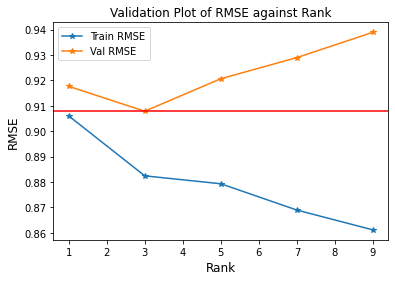

In [ ]:
values = [1,3,5,7,9]
train = [np.sqrt(0.8209), np.sqrt(0.7787), np.sqrt(0.7732), np.sqrt(0.7551), np.sqrt(0.7416)]
val = [np.sqrt(0.8421), np.sqrt(0.8242), np.sqrt(0.8476), np.sqrt(0.8630), np.sqrt(0.8816)]
plt.plot(values, train, "-*", label = 'Train RMSE')
plt.plot(values, val, "-*", label = 'Val RMSE')
plt.title("Validation Plot of RMSE against Rank")
plt.axhline(y=0.90785461, color='r', linestyle='-')

plt.ylabel("RMSE", fontsize = 12)
plt.xlabel("Rank", fontsize = 12)
plt.legend()

In [ ]:
#rank:3 	 MSE(train):0.7787 	 MSE(val):0.8242

In [ ]:
np.sqrt(0.8242)

DeviceArray(0.90785461, dtype=float64, weak_type=True)

In [ ]:
np.sqrt(0.8223)

DeviceArray(0.90680759, dtype=float64, weak_type=True)

### Choosing Low rank  = 3 with SGDM

In [ ]:
train_df = ratings_df.groupby('User_ID', group_keys=False).apply(lambda x: x.sample(frac=0.9, random_state=2603))
test_df = ratings_df[~ratings_df.index.isin(train_df.index)].reset_index(drop=True)
train_df = train_df.reset_index(drop=True)

In [ ]:
u_list_train = onp.array(train_df['User_ID'] - 1)
f_list_train = onp.array(train_df['id'])
u_list_test = np.array(test_df['User_ID'] - 1)
f_list_test = np.array(test_df['id'])
y_train = train_df['Rating']
y_test = test_df['Rating']

In [ ]:
r = 3
onp.random.seed(2603)
beta_init = onp.random.normal(0, scale=1, size=(6040 * r)).reshape(6040, r)
X = onp.random.normal(0, scale=1, size=(r * 3883)).reshape(r, 3883)

n = 30
m = 5000
beta = onp.copy(beta_init)
x = onp.copy(X)
y = onp.copy(y_train)
learning_rate = 0.9
gamma = 0.9

start_time = time.time()
beta_previous = onp.copy(beta)
x_previous = onp.copy(x)
N = len(u_list_train)
img_indices = onp.arange(N)

loss_history = []
train_list = []
test_list = []
loss_history_end_epoch = []
for epoch in range(n):
    n_minibatch = N // m + 1
    onp.random.shuffle(img_indices)

    all_loss_within_epoch = []
    for k in range(n_minibatch):
        batch_indices = onp.arange(k*m, (k+1)*m) % N
        batch_indices = img_indices[batch_indices]
        u_minibatch = u_list_train[batch_indices]
        f_minibatch = f_list_train[batch_indices]
        y_minibatch = y[batch_indices]

        grad_beta = MSE_grad_u(beta, x, y_minibatch, u_minibatch, f_minibatch)
        grad_x = MSE_grad_v(beta, x, y_minibatch, u_minibatch, f_minibatch)
        
        temp_beta = beta
        beta = temp_beta - learning_rate * grad_beta + gamma * (temp_beta - beta_previous)
        beta_previous = temp_beta

        temp_x = x
        x = temp_x - learning_rate * grad_x + gamma * (temp_x - x_previous)
        x_previous = temp_x

        loss_history.append(MSE(beta, x, y,u_list_train,f_list_train))
        all_loss_within_epoch.append(MSE(beta, x, y,u_list_train,f_list_train))
        # test_all_loss_within_epoch.append(MSE(beta, x, onp.copy(y_test), u_list_test,f_list_test))

    cur_loss = onp.mean(all_loss_within_epoch)
    loss_history_end_epoch.append(cur_loss)

    # print train and test MSE
    err_train = MSE(beta, x, y,u_list_train,f_list_train)
    train_list.append(err_train)
    err_test = MSE(beta, x, onp.copy(y_test), u_list_test,f_list_test)   
    test_list.append(err_test)     
    print(f"epoch:{epoch} \t Loss:{cur_loss:2.3f}  \t MSE(train):{err_train:2.4f} \t MSE(test):{err_test:2.4f}")

epoch:0 	 Loss:14.361  	 MSE(train):11.5011 	 MSE(test):11.6749
epoch:1 	 Loss:4.931  	 MSE(train):2.0008 	 MSE(test):2.0024
epoch:2 	 Loss:1.480  	 MSE(train):1.1813 	 MSE(test):1.1977
epoch:3 	 Loss:1.066  	 MSE(train):0.9850 	 MSE(test):1.0067
epoch:4 	 Loss:0.944  	 MSE(train):0.9121 	 MSE(test):0.9371
epoch:5 	 Loss:0.894  	 MSE(train):0.8776 	 MSE(test):0.9056
epoch:6 	 Loss:0.869  	 MSE(train):0.8587 	 MSE(test):0.8869
epoch:7 	 Loss:0.853  	 MSE(train):0.8468 	 MSE(test):0.8768
epoch:8 	 Loss:0.843  	 MSE(train):0.8384 	 MSE(test):0.8695
epoch:9 	 Loss:0.836  	 MSE(train):0.8319 	 MSE(test):0.8631
epoch:10 	 Loss:0.830  	 MSE(train):0.8271 	 MSE(test):0.8583
epoch:11 	 Loss:0.826  	 MSE(train):0.8225 	 MSE(test):0.8545
epoch:12 	 Loss:0.822  	 MSE(train):0.8186 	 MSE(test):0.8524
epoch:13 	 Loss:0.818  	 MSE(train):0.8148 	 MSE(test):0.8485
epoch:14 	 Loss:0.814  	 MSE(train):0.8115 	 MSE(test):0.8451
epoch:15 	 Loss:0.811  	 MSE(train):0.8082 	 MSE(test):0.8427
epoch:16 	 Loss

In [ ]:
np.sqrt(0.8126)

DeviceArray(0.90144329, dtype=float64, weak_type=True)

## 3.2.2 L-BFGS
### Cross validation to choose the best R

In [ ]:
train_df1 = ratings_df.groupby('User_ID', group_keys=False).apply(lambda x: x.sample(frac=0.9, random_state=2603))
train_df2 = train_df1.groupby('User_ID', group_keys=False).apply(lambda x: x.sample(frac=0.9, random_state=2603))
val_df2 = ratings_df[~ratings_df.index.isin(train_df2.index)].reset_index(drop=True)
train_df2 = train_df2.reset_index(drop=True)

In [ ]:
len(train_df)

900194

In [ ]:
len(train_df2)

810191

In [ ]:
len(val_df2)

190018

In [ ]:
u_list_train2 = onp.array(train_df2['User_ID'] - 1)
f_list_train2 = onp.array(train_df2['id'])
u_list_test2 = np.array(val_df2['User_ID'] - 1)
f_list_test2 = np.array(val_df2['id'])
y_train2 = train_df2['Rating']
y_val2 = val_df2['Rating']

In [ ]:
save_train = []
save_test = []

In [ ]:
start = time.time()
for i in range(1, 21):
    R = i
    onp.random.seed(2603)
    beta_init_ = onp.random.normal(0, scale=1/np.sqrt(6040 * R), size=(6040 * R)).reshape(6040, R)
    x_init = onp.random.normal(0, scale=1/np.sqrt(R * 3883), size=(R * 3883)).reshape(R, 3883)

    # initiation
    beta = onp.copy(beta_init_)
    x = onp.copy(x_init)
    y = onp.copy(y_train2)

    # get the dimensions
    x_dimx, x_dimy = x.shape
    beta_dimx, beta_dimy = beta.shape

    # we will concatenate all these coefficients and atoms into a long vector and apply LBFGS on that
    # this long vector if parameter will have dimension: atom_dimx*atom_dimy + coefs_dimx*coefs_dimy
    param_dim = x_dimx * x_dimy + beta_dimx * beta_dimy 

    # generate a random initial parameter
    param_init = onp.random.normal(0, 1/param_dim, size=param_dim)

    @jax.jit
    def extract_x_and_beta(param):
        """ helper function to extract the beta and x out of the long parameter vector """
        x = param[(beta_dimx * beta_dimy):]
        beta = param[:(beta_dimx * beta_dimy)]
        return x, beta

    @jax.jit
    def loss_RMSE(param, y, u_list, f_list):
        # extract the log atoms and coefs
        x_, beta_ = extract_x_and_beta(param)

        # make it positive by applying the function log(1+exp(x))
        beta1 = make_positive(beta_).reshape(beta_dimx, beta_dimy)
        x1 = make_positive(x_).reshape(x_dimx, x_dimy)
        
        # mean squared error 
        result = RMSE(beta1, x1, y, u_list, f_list)
        return result
    # automatic differentiation magic here!
    loss_RMSE_grad = jax.jit(jax.grad(loss_RMSE))

    #let's create a wrapper to make sure the output is a standard numpy gradient
    def loss_MSE_grad_wrapper(param, y, u_list, f_list):
        return onp.array(loss_RMSE_grad(param, y, u_list, f_list))

    #train the model
    traj = scipy.optimize.minimize(fun = lambda x: loss_RMSE(param = x, y = y, u_list = u_list_train2, f_list = f_list_train2), #functino to minimize
                                x0 = param_init, #initial guess
                                method = 'L-BFGS-B',  #we want to use L-BFGS
                                jac = lambda x: loss_RMSE_grad_wrapper(param = x, y = y, u_list = u_list_train2, f_list = f_list_train2), #function that computes the gradient
                                tol = 10**-10,
                                options={"maxiter":250})  #maximum number of iteration
    train_mse = loss_RMSE(traj["x"], y, u_list_train2, f_list_train2)
    test_mse = loss_RMSE(traj["x"], onp.copy(y_val2), u_list_test2, f_list_test2)
    save_train.append(train_mse)
    save_test.append(test_mse)
    print(f"rank:{i} \t \t RMSE(train):{train_mse:5.5} \t RMSE(val):{test_mse:5.5}")

rank:1 	 	 RMSE(train):0.90129 	 RMSE(val):0.91264
rank:2 	 	 RMSE(train):0.8612 	 RMSE(val):0.88526
rank:3 	 	 RMSE(train):0.84215 	 RMSE(val):0.87918
rank:4 	 	 RMSE(train):0.82637 	 RMSE(val):0.8757
rank:5 	 	 RMSE(train):0.81037 	 RMSE(val):0.87023
rank:6 	 	 RMSE(train):0.79877 	 RMSE(val):0.86978
rank:7 	 	 RMSE(train):0.78843 	 RMSE(val):0.86737
rank:8 	 	 RMSE(train):0.78106 	 RMSE(val):0.87279
rank:9 	 	 RMSE(train):0.77264 	 RMSE(val):0.87468
rank:10 	 	 RMSE(train):0.76564 	 RMSE(val):0.87618
rank:11 	 	 RMSE(train):0.75975 	 RMSE(val):0.87809
rank:12 	 	 RMSE(train):0.75252 	 RMSE(val):0.88255
rank:13 	 	 RMSE(train):0.79144 	 RMSE(val):0.91636
rank:14 	 	 RMSE(train):0.78535 	 RMSE(val):0.9199
rank:15 	 	 RMSE(train):0.77883 	 RMSE(val):0.92359
rank:16 	 	 RMSE(train):0.77338 	 RMSE(val):0.92311
rank:17 	 	 RMSE(train):0.77134 	 RMSE(val):0.92652
rank:18 	 	 RMSE(train):0.76773 	 RMSE(val):0.93032
rank:19 	 	 RMSE(train):0.764 	 RMSE(val):0.93097
rank:20 	 	 RMSE(train):0.

In [ ]:
save_train = save_train[1:]


In [ ]:
save_test = save_test[1:]

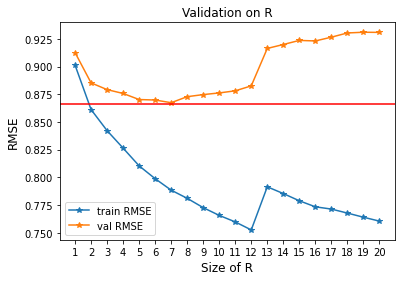

In [ ]:
iter = list(range(1, 21))
plt.plot(iter, save_train, "-*", label = 'train RMSE')
plt.plot(iter, save_test, "-*", label = 'val RMSE')
plt.title("Validation on R")
plt.ylabel("RMSE", fontsize = 12)
plt.xlabel("Size of R", fontsize = 12)
plt.xticks(iter)  
plt.axhline(y=0.866, color='r', linestyle='-')
plt.legend()


([<matplotlib.axis.XTick at 0x7f6bd805f450>,
 <a list of 21 Text major ticklabel objects>)

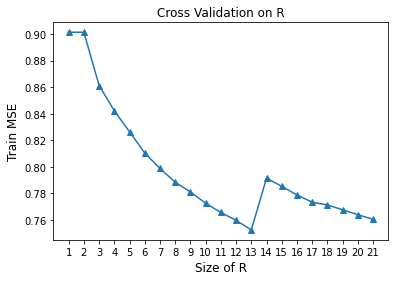

In [ ]:
iter = list(range(1, len(save_train) + 1))
plt.plot(iter, save_train, "-^")
plt.title("Cross Validation on R")
plt.ylabel("Train MSE", fontsize = 12)
plt.xlabel("Size of R", fontsize = 12)
plt.xticks(iter)  

([<matplotlib.axis.XTick at 0x7f6bd5383b50>,
 <a list of 21 Text major ticklabel objects>)

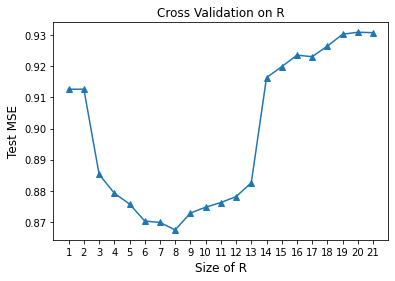

In [ ]:
iter = list(range(1, len(save_train) + 1))
plt.plot(iter, save_test, "-^")
plt.title("Cross Validation on R")
plt.ylabel("Test MSE", fontsize = 12)
plt.xlabel("Size of R", fontsize = 12)
plt.xticks(iter)  

### Low rank  = 7 with LBFGS

In [ ]:
R = 7
onp.random.seed(2603)
beta_init_ = onp.random.normal(0, scale=1/np.sqrt(6040 * R), size=(6040 * R)).reshape(6040, R)
x_init = onp.random.normal(0, scale=1/np.sqrt(R * 3883), size=(R * 3883)).reshape(R, 3883)

# initiation
beta = onp.copy(beta_init)
x = onp.copy(X)
y = onp.copy(y_train)

# get the dimensions
x_dimx, x_dimy = x.shape
beta_dimx, beta_dimy = beta.shape

# we will concatenate all these coefficients and atoms into a long vector and apply LBFGS on that
# this long vector if parameter will have dimension: atom_dimx*atom_dimy + coefs_dimx*coefs_dimy
param_dim = x_dimx * x_dimy + beta_dimx * beta_dimy 

# generate a random initial parameter
param_init = onp.random.normal(0, 1/param_dim, size=param_dim)

@jax.jit
def extract_x_and_beta(param):
    """ helper function to extract the beta and x out of the long parameter vector """
    x = param[(beta_dimx * beta_dimy):]
    beta = param[:(beta_dimx * beta_dimy)]
    return x, beta

@jax.jit
def loss_RMSE(param, y, u_list, f_list):
    # extract the log atoms and coefs
    x_, beta_ = extract_x_and_beta(param)

    # make it positive by applying the function log(1+exp(x))
    beta1 = make_positive(beta_).reshape(beta_dimx, beta_dimy)
    x1 = make_positive(x_).reshape(x_dimx, x_dimy)
    
    # mean squared error 
    result = RMSE(beta1, x1, y, u_list, f_list)
    return result
# automatic differentiation magic here!
loss_RMSE_grad = jax.jit(jax.grad(loss_RMSE))

#let's create a wrapper to make sure the output is a standard numpy gradient
def loss_RMSE_grad_wrapper(param, y, u_list, f_list):
    return onp.array(loss_RMSE_grad(param, y, u_list, f_list))


loss_history = []  #to save the loss trajectory
time_history = []  #to save the compute time
iteration_index = 0

def save_traj(param):
    """ a function that saves a few statistics for later analysis"""
    global iteration_index
    iteration_index += 1
    current_loss = loss_RMSE(param, y, u_list_train, f_list_train)
    current_loss_test = loss_RMSE(param, onp.copy(y_test), u_list_test, f_list_test)

    # display the loss every 10 iterations
    if iteration_index % 10 == 0:
        print(f"iteration:{iteration_index} \t \t RMSE(train):{current_loss:5.5} \t RMSE(val):{current_loss_test:5.5}")
    
    # record everything
    loss_history.append(current_loss)
    time_history.append(time.time() - start)

start = time.time()
traj = scipy.optimize.minimize(fun = lambda x: loss_RMSE(param = x, y = y, u_list = u_list_train, f_list = f_list_train), #functino to minimize
                                x0 = param_init, #initial guess
                                method = 'L-BFGS-B',  #we want to use L-BFGS
                                jac = lambda x: loss_RMSE_grad_wrapper(param = x, y = y, u_list = u_list_train, f_list = f_list_train), #function that computes the gradient
                                callback = save_traj, #a function used to save some results for later pltting
                                tol = 10**-10,
                                options={"maxiter":250})  #maximum number of iteration

iteration:10 	 	 RMSE(train):1.0468 	 RMSE(val):1.0509
iteration:20 	 	 RMSE(train):0.95077 	 RMSE(val):0.95804
iteration:30 	 	 RMSE(train):0.94053 	 RMSE(val):0.94896
iteration:40 	 	 RMSE(train):0.93827 	 RMSE(val):0.94719
iteration:50 	 	 RMSE(train):0.93748 	 RMSE(val):0.94657
iteration:60 	 	 RMSE(train):0.93714 	 RMSE(val):0.94626
iteration:70 	 	 RMSE(train):0.93695 	 RMSE(val):0.94614
iteration:80 	 	 RMSE(train):0.93684 	 RMSE(val):0.94611
iteration:90 	 	 RMSE(train):0.93678 	 RMSE(val):0.94613
iteration:100 	 	 RMSE(train):0.93673 	 RMSE(val):0.94612
iteration:110 	 	 RMSE(train):0.93632 	 RMSE(val):0.94595
iteration:120 	 	 RMSE(train):0.91674 	 RMSE(val):0.93168
iteration:130 	 	 RMSE(train):0.89984 	 RMSE(val):0.92084
iteration:140 	 	 RMSE(train):0.8795 	 RMSE(val):0.9122
iteration:150 	 	 RMSE(train):0.85866 	 RMSE(val):0.90482
iteration:160 	 	 RMSE(train):0.84136 	 RMSE(val):0.90226
iteration:170 	 	 RMSE(train):0.82518 	 RMSE(val):0.90457
iteration:180 	 	 RMSE(trai

Text(0, 0.5, 'MSE reconstruction')

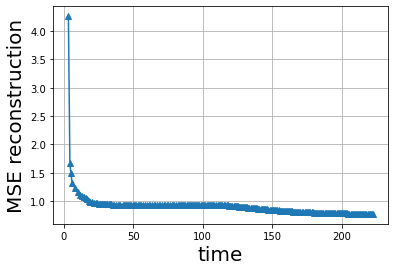

In [ ]:
plt.plot(time_history, loss_history, "-^")
plt.grid(True)
plt.xlabel("time", fontsize=20)
plt.ylabel("MSE reconstruction", fontsize=20)

In [ ]:
def RMSE(U,V,Y,u_list_train,f_list_train):
    predictions = (U @ V)[u_list_train.astype(int), f_list_train.astype(int)]
    errors = Y - predictions
    return (np.mean(errors**2))**(1/2)

@jax.jit
def loss_RMSE(param, y, u_list, f_list):
    # extract the log atoms and coefs
    x_, beta_ = extract_x_and_beta(param)

    # make it positive by applying the function log(1+exp(x))
    beta1 = make_positive(beta_).reshape(beta_dimx, beta_dimy)
    x1 = make_positive(x_).reshape(x_dimx, x_dimy)
    
    # mean squared error 
    result = RMSE(beta1, x1, y, u_list, f_list)
    return result

In [ ]:
# train rmse
loss_RMSE(traj["x"], y, u_list_train, f_list_train)

DeviceArray(0.77445757, dtype=float64)

In [ ]:
# test rmse
loss_RMSE(traj["x"], onp.copy(y_test), u_list_test, f_list_test)

DeviceArray(0.91576896, dtype=float64)

# **-------**